### This original code is from https://www.kaggle.com/code/senkin13/2nd-place-gru-cite, modified by Junping Luo and Sophia Luo. Code we wrote and written by the author is specified in the report document.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [10]:
feature_path = './single-cell-features'

train_df = pd.read_feather(feature_path+'/train_cite_inputs_id.feather')
test_df = pd.read_feather(feature_path+'/test_cite_inputs_id.feather')

train_cite_X = np.load(feature_path+'/train_cite_X.npy')
test_cite_X = np.load(feature_path+'/test_cite_X.npy')

train_cite_y = np.load(feature_path+'/train_cite_targets.npy') 

# train_X, test_X, train_Y, test_Y = train_test_split(train_cite_X,train_cite_y,test_size=0.2,train_size=0.8)
# train_df = train_df_p[:train_X.shape[0]]
# test_df = train_df_p[train_X.shape[0]:]

In [11]:
train_df.shape,test_df.shape,train_cite_X.shape,test_cite_X.shape,train_cite_y.shape

((70988, 4), (48663, 4), (70988, 1009), (48663, 1009), (70988, 140))

In [12]:
def plot_data(data, title=''):
    means, stds, medians = [], [], []
    for train_data in data.transpose():
        mean = train_data.mean()
        std = train_data.std()
        median = np.median(train_data)
        means.append(mean)
        stds.append(std)
        medians.append(median)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot([means,medians,stds], labels=["Mean","Median","Std"])
    plt.title(title)
    # plt.hist(means,bins=20)
    plt.show()

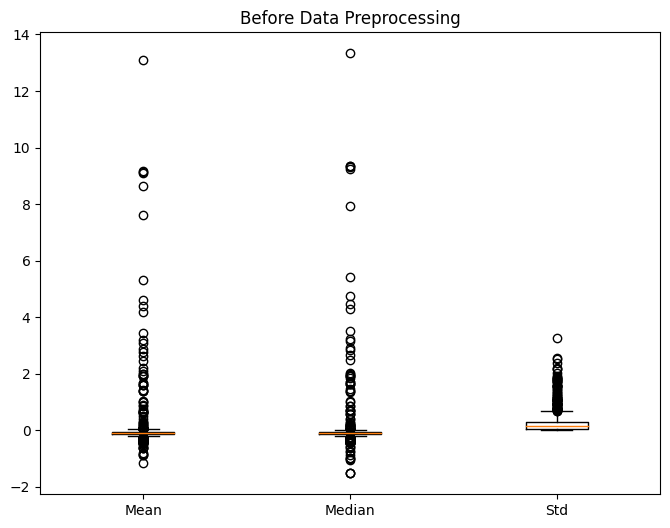

In [13]:
plot_data(train_cite_X, "Before Data Preprocessing")

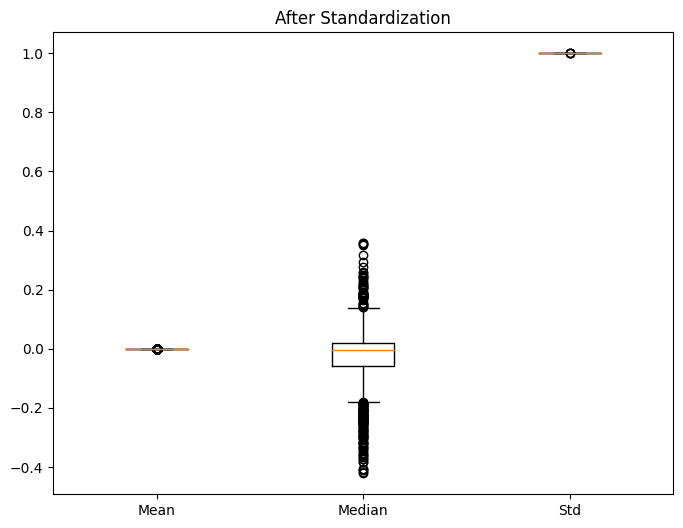

In [23]:
scaler = preprocessing.StandardScaler().fit(train_cite_X)
X_standardized = scaler.transform(train_cite_X)
plot_data(X_standardized, "After Standardization")

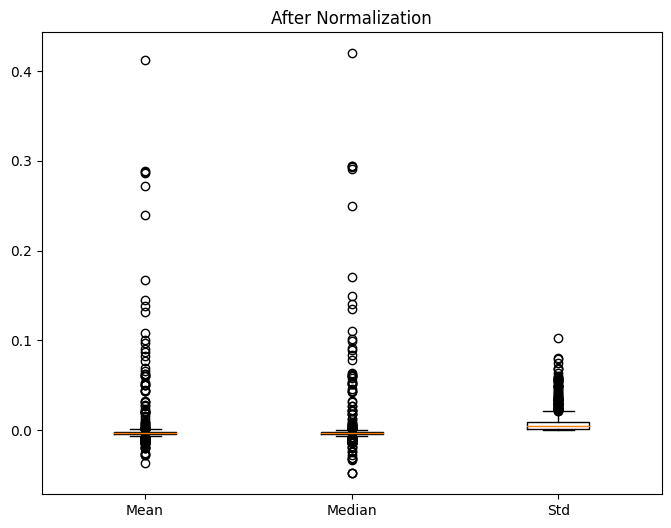

In [15]:
normalizer = preprocessing.Normalizer().fit(train_cite_X)
X_normalized = normalizer.transform(train_cite_X)
plot_data(X_normalized, "After Normalization")

In [16]:
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold

def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


def zscore(x):
    x_zscore = []
    for i in range(x.shape[0]):
        x_row = x[i]
        x_row = (x_row - np.mean(x_row)) / np.std(x_row)
        x_zscore.append(x_row)
    x_std = np.array(x_zscore)    
    return x_std


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_X, train_y, list_IDs, shuffle, batch_size, labels, ): 
        self.train_X = train_X
        self.train_y = train_y
        self.list_IDs = list_IDs        
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.list_IDs) // self.batch_size
        return ct
    
    def __getitem__(self, idx):
        'Generate one batch of data'
        indexes = self.list_IDs[idx*self.batch_size:(idx+1)*self.batch_size]
    
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        if self.labels: return X, y
        else: return X
 
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.list_IDs) )
        if self.shuffle: 
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'    
        X = self.train_X[list_IDs_temp]
        y = self.train_y[list_IDs_temp]        
        return X, y
    
    
def nn_kfold(train_df, train_cite_X, train_cite_y, test_df, test_cite_X, network, folds, epochs, lr):
    oof_preds = np.zeros((train_df.shape[0],140))
    sub_preds = np.zeros((test_df.shape[0],140))
    cv_corr = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df,)):          
        print (n_fold)
        train_x = train_cite_X[train_idx]
        valid_x = train_cite_X[valid_idx]
        train_y = train_cite_y[train_idx]
        valid_y = train_cite_y[valid_idx]

        train_x_index = train_df.iloc[train_idx].reset_index(drop=True).index
        valid_x_index = train_df.iloc[valid_idx].reset_index(drop=True).index
        
        model = network(train_cite_X.shape[1], lr)
#         filepath = model_name+'_'+f'{n_fold}-{epochs}'+'.h5'
#         es = tf.keras.callbacks.EarlyStopping(patience=10, mode='min', verbose=1) 
#         checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=filepath, save_best_only=True,save_weights_only=True,mode='min') 
#         reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=6, verbose=1)
    
        train_dataset = DataGenerator(
            train_x,
            train_y,
            list_IDs=train_x_index, 
            shuffle=True, 
            batch_size=BATCH_SIZE, 
            labels=True,
        )
        
        valid_dataset = DataGenerator(
            valid_x,
            valid_y,
            list_IDs=valid_x_index, 
            shuffle=False, 
            batch_size=BATCH_SIZE, 
            labels=True,
        )
    
        hist = model.fit(train_dataset,
                        validation_data=valid_dataset,  
                        epochs=epochs, 
#                         callbacks=[checkpoint,es,reduce_lr_loss],
#                         callbacks=[checkpoint],
                        workers=4,
                        verbose=1)  
    
#         model.load_weights(filepath)
        
        oof_preds[valid_idx] = model.predict(valid_x, 
                                batch_size=BATCH_SIZE,
                                verbose=1)
        oof_corr = correlation_score(valid_y,  oof_preds[valid_idx])
        cv_corr.append(oof_corr)
        print (cv_corr)       
        
#         sub_preds += model.predict(test_cite_X, test_cite_X
            
        del model
        gc.collect()
        tf.keras.backend.clear_session()    
    cv = correlation_score(train_cite_y,  oof_preds)
    print ('Overall:',cv)           
    return oof_preds

## MLP Model

In [17]:
def cite_mlp_model(len_num, lr):
    input_num = tf.keras.Input(shape=(len_num))     

    x = input_num
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x)   
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x)  
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x)  
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x)  
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x) 
    
    output = tf.keras.layers.Dense(140, activation='linear')(x) 

    model = tf.keras.models.Model(input_num, output)
    
#     lr=0.0005
    weight_decay = 0.0001
    
    opt = tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )    

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt,)
    model.summary()
    return model

## CNN Model

In [18]:
def cite_cnn_model(len_num, lr):
    
    input_num = tf.keras.Input(shape=(len_num,))     

    x = input_num
    
    
    
    reshape = tf.keras.layers.Reshape((len_num, 1))(x)
    x_conv = tf.keras.layers.Conv1D(4, 
                     5,
                     strides=1,
                     dilation_rate=3,
                     activation="ReLU")(reshape)
    x_conv = tf.keras.layers.Dropout(0.1)(x_conv)
    x_conv = tf.keras.layers.Conv1D(4, 
                     5,
                     strides=1,
                     dilation_rate=3,
                     activation="ReLU")(reshape)
    x_conv = tf.keras.layers.Dropout(0.1)(x_conv)
    x = tf.keras.layers.Flatten()(x)
    
#     x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
#     x = tf.keras.layers.Dropout(0.1)(x)   
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x)  
    x = tf.keras.layers.Dense(1500,activation ='ReLU',)(x)    
    x = tf.keras.layers.Dropout(0.1)(x)  

    
    output = tf.keras.layers.Dense(140, activation='linear')(x) 

    model = tf.keras.models.Model(input_num, output)
    
#     lr=0.0005
    weight_decay = 0.0001
    
    opt = tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )    

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt,)
    model.summary()
    return model

## Data Preprocessing Method Selection

In [19]:
# Hyperparameters
EPOCHS = [1, 3, 5, 10, 20]
LRs = [0.0001, 0.0005, 0.001, 0.005]
BATCH_SIZE = 600
LR_FACTOR = 0.1
SEED = 666
folds = KFold(n_splits= 5, shuffle=True, random_state=SEED)

In [20]:
mlp_score_list_raw = np.empty([len(EPOCHS)])
lr = 0.0005
for i, epoch in enumerate(EPOCHS):
    oof_preds_mlp = nn_kfold(train_df, train_cite_X, train_cite_y, test_df, test_cite_X, cite_mlp_model, folds, epoch, lr)
    mlp_score_list_raw[i] = correlation_score(train_cite_y, oof_preds_mlp)

0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0   

 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.8637312172980185, 0.8757322717535504, 0.8772502078832907, 0.8730915242404715]
4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)    

 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
          

                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 2s 14ms/step - loss: 4.3408 - val_loss: 2.9162
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 3.0044 - val_loss: 2.8349
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 2.8827 - val_loss: 2.5532
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 2.9364 - val_loss: 2.9342
Epoch 5/5
24/24 [==============================] - 0s 2ms/step
[0.8934777285682761]
1
Model: "model"
_________________________________

Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 12ms/step - loss: 4.9101 - val_loss: 2.9608
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 3.2721 - val_loss: 3.1854
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 2.8796 - val_loss: 2.5569
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 2.7025 - val_loss: 2.7001
Epoch 5/5
24/24 [==============================] - 0s 2ms/step
[0.8934777285682761, 0.8953412215634448, 0.8940251396496356, 0.8956067486085454]
4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000  

                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 1s 12ms/step - loss: 4.4435 - val_loss: 2.9071
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 2.9853 - val_loss: 2.7871
Epoch 3/10
94/94 [==============================] - 1s 11ms/step - loss: 2.7950 - val_loss: 2.8241
Epoch 4/10
94/94 [==============================] - 1s 11ms/step - loss: 2.6793 - val_loss: 2.5054
Epoch 5/10
94/94 [==============================] - 1s 11ms/step - loss: 2.7849 - val_loss: 3.1301
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 3.1603 - val_loss: 3.1852
Epoch 7/10
94/94 [==============================] - 1s 11ms/step - loss: 2.8557 - val_loss: 2.4641
Epoch 8/10
94/94 [==============================] - 1s 12ms/step - loss: 2.6748 - val_loss: 2.531

 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
          

                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 4.6932 - val_loss: 3.8307
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 3.1190 - val_loss: 2.6767
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8444 - val_loss: 2.5564
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7510 - val_loss: 2.7565
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 3.0736 - val_loss: 2.8482
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.6111 - val_loss: 2.4866
Epoch 7/20
94/94 [==============================] - 1s 12ms/step

                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 5.9140 - val_loss: 3.2752
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 3.2288 - val_loss: 3.5127
Epoch 3/20
94/94 [==============================] - 1s 12ms/step - loss: 2.9919 - val_loss: 2.8786
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8724 - val_loss: 2.5454
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7782 - val_loss: 2.5944
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7456 - val_loss: 2.4970
Epoch 7/20
94/94 [==============================] - 1s 11ms/step

In [24]:
mlp_score_list_standardized = np.empty([len(EPOCHS)])
lr = 0.0005
for i, epoch in enumerate(EPOCHS):
    oof_preds_mlp = nn_kfold(train_df, X_standardized, train_cite_y, test_df, test_cite_X, cite_cnn_model, folds, epoch, lr)
    mlp_score_list_standardized[i] = correlation_score(train_cite_y, oof_preds_mlp)

0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               2101

 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
94/94 [==============================] - 1s 11ms/step - loss: 3.5793 - val_loss: 2.4487
Epoch 2/3
94/94 [==============================] - 1s 8ms/step - loss: 2.5957 - val_loss: 2.5543
Epo

Overall: 0.9020405867591177
0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (N

 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 10ms/step - loss: 3.7806 - val_loss: 2.4678
Epoch 2/5
94/94 [==============================] - 1s 8ms/step - loss: 2.5278 - val_loss: 2.3705
Epo

Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 2.3987 - val_loss: 2.3403
Epoch 7/10
94/94 [==============================] - 1s 9ms/step - loss: 2.3076 - val_loss: 2.3577
Epoch 8/10
94/94 [==============================] - 1s 8ms/step - loss: 2.1996 - val_loss: 2.2861
Epoch 9/10
94/94 [==============================] - 1s 8ms/step - loss: 2.7505 - val_loss: 2.5272
Epoch 10/10
24/24 [==============================] - 0s 2ms/step
[0.904093399974477, 0.9043078249204631, 0.9033729746719882]
3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
    

Epoch 14/20
94/94 [==============================] - 1s 8ms/step - loss: 2.1081 - val_loss: 2.4884
Epoch 15/20
94/94 [==============================] - 1s 8ms/step - loss: 2.1187 - val_loss: 2.5479
Epoch 16/20
94/94 [==============================] - 1s 8ms/step - loss: 2.1441 - val_loss: 2.3132
Epoch 17/20
94/94 [==============================] - 1s 8ms/step - loss: 2.2817 - val_loss: 3.0953
Epoch 18/20
94/94 [==============================] - 1s 9ms/step - loss: 2.1390 - val_loss: 2.3796
Epoch 19/20
94/94 [==============================] - 1s 8ms/step - loss: 1.9631 - val_loss: 2.3536
Epoch 20/20
24/24 [==============================] - 0s 2ms/step
[0.9043312822703139]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 100

 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 3.8116 - val_loss: 2.4195
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 2.5301 - val_loss: 2.3250
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 2.4231 - val_loss: 2.3677
Epoch 4/20
94/94 [=================

In [25]:
mlp_score_list_normalized = np.empty([len(EPOCHS)])
lr = 0.0005
for i, epoch in enumerate(EPOCHS):
    oof_preds_mlp = nn_kfold(train_df, X_normalized, train_cite_y, test_df, test_cite_X, cite_mlp_model, folds, epoch, lr)
    mlp_score_list_normalized[i] = correlation_score(train_cite_y, oof_preds_mlp)

0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0   

 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 3ms/step
[0.8045623940637852, 0.8055678974780351, 0.8036643849487698, 0.8039681607178832]
4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)    

 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
          

                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 2s 15ms/step - loss: 5.6533 - val_loss: 4.6330
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 4.0921 - val_loss: 3.4735
Epoch 3/5
94/94 [==============================] - 1s 12ms/step - loss: 3.5653 - val_loss: 3.1584
Epoch 4/5
94/94 [==============================] - 1s 13ms/step - loss: 3.1050 - val_loss: 3.2386
Epoch 5/5
24/24 [==============================] - 0s 3ms/step
[0.882738462236108]
1
Model: "model"
__________________________________

Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 2s 13ms/step - loss: 5.8744 - val_loss: 4.3615
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 4.3534 - val_loss: 3.6349
Epoch 3/5
94/94 [==============================] - 1s 12ms/step - loss: 3.4820 - val_loss: 3.4778
Epoch 4/5
94/94 [==============================] - 1s 13ms/step - loss: 3.1626 - val_loss: 2.7893
Epoch 5/5
24/24 [==============================] - 0s 2ms/step
[0.882738462236108, 0.8866443664554827, 0.8845206106355987, 0.8836066556720596]
4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   

                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 1s 12ms/step - loss: 5.3617 - val_loss: 4.4765
Epoch 2/10
94/94 [==============================] - 1s 12ms/step - loss: 3.8264 - val_loss: 3.2526
Epoch 3/10
94/94 [==============================] - 1s 12ms/step - loss: 3.1878 - val_loss: 2.8831
Epoch 4/10
94/94 [==============================] - 1s 12ms/step - loss: 2.9184 - val_loss: 2.8360
Epoch 5/10
94/94 [==============================] - 1s 11ms/step - loss: 2.8615 - val_loss: 2.8482
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 2.8737 - val_loss: 2.6362
Epoch 7/10
94/94 [==============================] - 1s 12ms/step - loss: 2.6954 - val_loss: 2.6146
Epoch 8/10
94/94 [==============================] - 1s 12ms/step - loss: 2.6849 - val_loss: 2.602

 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
          

                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 5.2086 - val_loss: 3.7882
Epoch 2/20
94/94 [==============================] - 1s 12ms/step - loss: 3.5554 - val_loss: 3.2357
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 3.1271 - val_loss: 3.0171
Epoch 4/20
94/94 [==============================] - 1s 12ms/step - loss: 2.9579 - val_loss: 2.8227
Epoch 5/20
94/94 [==============================] - 1s 12ms/step - loss: 3.0205 - val_loss: 2.8156
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7637 - val_loss: 2.6393
Epoch 7/20
94/94 [==============================] - 1s 12ms/step

                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 5.6986 - val_loss: 4.6630
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 4.1360 - val_loss: 3.4622
Epoch 3/20
94/94 [==============================] - 1s 12ms/step - loss: 3.3546 - val_loss: 3.0722
Epoch 4/20
94/94 [==============================] - 1s 12ms/step - loss: 3.0699 - val_loss: 2.7439
Epoch 5/20
94/94 [==============================] - 1s 12ms/step - loss: 2.8326 - val_loss: 2.9167
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8707 - val_loss: 2.7548
Epoch 7/20
94/94 [==============================] - 1s 11ms/step

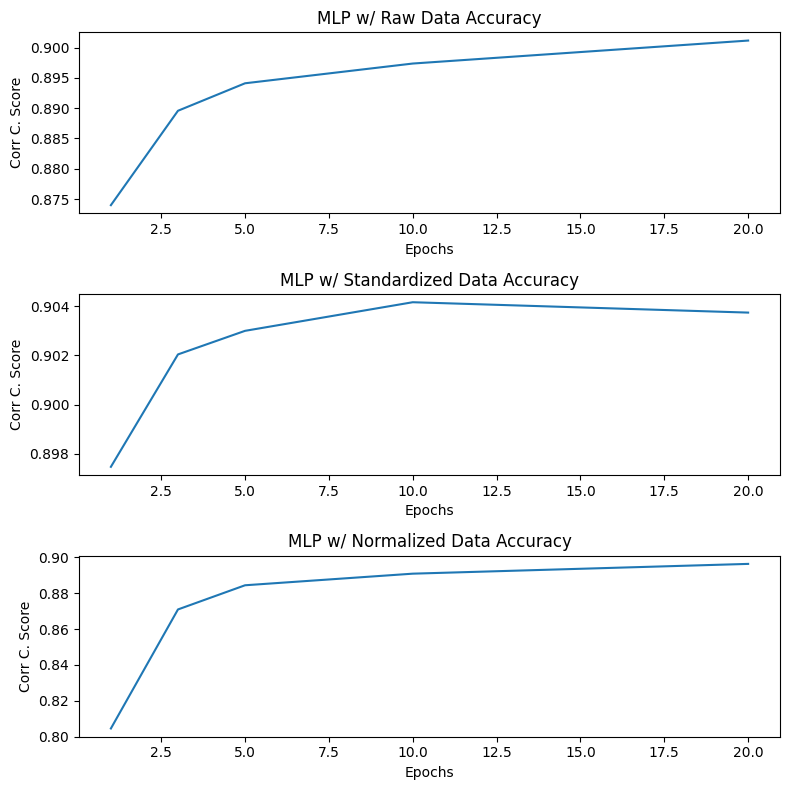

In [38]:
_, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(EPOCHS, mlp_score_list_raw)
ax[0].title.set_text("MLP w/ Raw Data Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Corr C. Score")
ax[1].plot(EPOCHS, mlp_score_list_standardized)
ax[1].title.set_text("MLP w/ Standardized Data Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Corr C. Score")
ax[2].plot(EPOCHS, mlp_score_list_normalized)
ax[2].title.set_text("MLP w/ Normalized Data Accuracy")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Corr C. Score")
plt.tight_layout()
plt.show()

In [28]:
print(max(mlp_score_list_raw), max(mlp_score_list_standardized), max(mlp_score_list_normalized))

0.9011564670196937 0.9041613796014343 0.896340503753461


## Model Evaluation

In [39]:
# MLP
mlp_score_list = np.empty([len(EPOCHS), len(LRs)])

for i, epoch in enumerate(EPOCHS):
    for j, lr in enumerate(LRs):
        oof_preds_mlp = nn_kfold(train_df, train_cite_X, train_cite_y, test_df, test_cite_X, cite_mlp_model, folds, epoch, lr)
        mlp_score_list[i][j] = correlation_score(train_cite_y, oof_preds_mlp)

0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0   

 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.87183034117755, 0.8730642361817689, 0.8643150444114481, 0.8667102422545229]
4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)      

 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.87847333

 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
          

Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.8557750733565759, 0.8543185461533975, 0.8538403026076506, 0.8485176523285219, 0.8519584387071619]
Overall: 0.8528820771209232
0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)          

 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.8035931629017463, 0.8047563580152379, 0.8022401850615702, 0.7994324921242091]
4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]  

 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
          

                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
94/94 [==============================] - 2s 14ms/step - loss: 4.2172 - val_loss: 2.9501
Epoch 2/3
94/94 [===============

                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4

 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
94/94 [==============================] - 2s 15ms/step - loss: 4654.7456 - val_loss: 4.7763
Epoch 2/3
94/94 [==============================] - 1s 12ms/step - loss: 5.5117 - val_loss: 4.7606
Epoch 3/3
24/24 [==============================] - 0s 2ms/step
[0.8311657957151658]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)       

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0     

                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4

 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 

                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 2s 13ms/step - loss: 5.2277 - val_loss: 3.4261
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 3.2152 - val_loss: 2.7541
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 2.9599 - val_loss: 2.6227
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 2.7826 - val_loss: 2.5840
Ep

 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 12ms/step - loss: 6.5083 - val_loss: 3.3861
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 3.4339 - val_loss: 2.9253
Epoch 3/5
94/94 [==============================] - 1s 12ms/step - loss: 2.9555 - val_loss: 2.6848
Epoch 4/5
94/94 [==============================] - 1s 12ms/step - loss: 3.2535 - val_loss: 2.7802
Epoch 5/5
24/24 [==============================] - 0s 2ms/step
[0.8889889909272818, 0.889088966651251]
2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
              

94/94 [==============================] - 1s 11ms/step - loss: 3.5813 - val_loss: 3.4298
Epoch 5/5
24/24 [==============================] - 0s 3ms/step
[0.8572280577479541, 0.8648342071480717, 0.8691486815101461]
3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                             

                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 2s 13ms/step - loss: 5.3142 - val_loss: 3.2428
Epoch 2/10
94/94 [==============================] - 1s 12ms/step - loss: 3.1458 - val_loss: 2.7068
Epoch 3/10
94/94 [==============================] - 1s 12ms/step - loss: 2.8365 - val_loss: 2.5027
Epoch 4/10
94/94 [==============================] - 1s 12ms/step - loss: 2.6932 - val_loss: 2.4409
Epoch 5/10
94/94 [==============================] - 1s 12ms/step - loss: 2.5945 - val_loss: 2.4062
Epoch 6/10
94/94 [=============

                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3

                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 1s 12ms/step - loss: 5.9277 - val_loss: 3.5381
Epoch 2/10
94/94 [=============

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0     

_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 2s 12ms/step - loss: 1808.8696 - val_loss: 4.6671
Epoch 2/10
94/94 [==============================] - 1s 13ms/step - loss: 4.6155 - val_loss: 4.4562
Epoch 3/10
94/94 [==============================] - 1s 11ms/step - loss: 3.8575 - val_loss: 3.4437
Epoch 4/10
94/94 [==============================] - 1s 12ms/step - loss: 3.9529 - val_loss: 3.3346
Epoch 5/10
94/94 [==============================] - 1s 12ms/step - loss: 3.4261 - val_loss: 3.1113
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 3.3176 - val_loss: 2.9995
Epoch 7/10
94/94 [==============================] - 1s 11ms/step - loss: 3.1804 - val_loss: 2.9779
Epoch 8/10
94/94 [==============================] - 1s 12ms/step - loss: 3.0383 - val_loss: 2.9159
Epoch 9/10
94/94 [==============================] - 1s 12ms/step - loss: 2.9276 - val_loss: 2.6781
Epoch 10/10
24/24 [=====================

                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 140)               210140    
                                                                 
Total para

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 5.0443 - val_loss: 3.3425
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 3.1450 - val_loss: 2.7879
Epoch 3/20
94/94 [==============================] - 1s 12ms/step - loss: 2.8457 - val_loss: 2.5267
Epoch 4/20
94/94 [==============================] - 1s 12ms/step - loss: 2.6851 - val_loss: 2.4568
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 2.5998 - val_loss: 2.4076
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.5269 - val_loss: 2.3604
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 2.5901 - val_loss: 2.3500
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 2.4734 - val_loss: 2.3124
Epoch 9/20
94/94 [==============================] - 1s 11ms/step

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 5.2737 - val_loss: 3.1080
Epoch 2/20
94/94 [==============================] - 1s 12ms/step - loss: 3.2078 - val_loss: 2.6650
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8910 - val_loss: 2.5945
Epoch 4/20
94/94 [==============================] - 1s 12ms/step - loss: 2.7420 - val_loss: 2.4770
Epoch 5/20
94/94 [==============================] - 1s 12ms/step - loss: 2.6450 - val_loss: 2.3613
Epoch 6/20
94/94 [==============================] - 1s 12ms/step - loss: 2.5571 - val_loss: 2.3455
Epoch 7/20
94/94 [==============================] - 1s 12ms/step - loss: 2.5003 - val_loss: 2.3003
Epoch 8/20
94/94 [==============================] - 1s 12ms/step - loss: 2.4862 - val_loss: 2.2809
Epoch 9/20
94/94 [==============================] - 1s 12ms/step

                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 2s 13ms/step - loss: 4.7693 - val_loss: 3.1708
Epoch 2/20
94/94 [==============================] - 1s 12ms/step - loss: 3.0937 - val_loss: 2.8564
Epoch 3/20
94/94 [==============================] - 1s 13ms/step - loss: 2.8223 - val_loss: 2.8328
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8247 - val_loss: 2.5224
Epoch 5/20
94/94 [==============================] - 1s 12ms/step - loss: 2.6450 - val_loss: 2.7802
Epoch 6/20
94/94 [==============================] - 1s 12ms/step - loss: 2.8905 - val_loss: 2.6146
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 2.6268 - val_loss: 2.4353
Epoch 8/20
94/94 [==============================] - 1s 12ms/step - loss: 2.5442 - val_loss: 2.548

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 5.0085 - val_loss: 3.1453
Epoch 2/20
94/94 [==============================] - 1s 12ms/step - loss: 3.0787 - val_loss: 2.7920
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 2.9312 - val_loss: 2.7395
Epoch 4/20
94/94 [==============================] - 1s 12ms/step - loss: 2.8387 - val_loss: 2.6968
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7573 - val_loss: 2.5617
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.5935 - val_loss: 2.4575
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7530 - val_loss: 2.7734
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7267 - val_loss: 2.4491
Epoch 9/20
94/94 [==============================] - 1s 11ms/step

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 4.2972 - val_loss: 2.8421
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 3.0636 - val_loss: 3.6543
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 2.9679 - val_loss: 2.5913
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7246 - val_loss: 2.5451
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 2.6047 - val_loss: 2.4771
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8529 - val_loss: 2.6027
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 2.6000 - val_loss: 2.4724
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8605 - val_loss: 2.6874
Epoch 9/20
94/94 [==============================] - 1s 11ms/step

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 4.9231 - val_loss: 3.4404
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 3.1165 - val_loss: 2.7019
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 2.9561 - val_loss: 2.7856
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 2.9845 - val_loss: 2.6102
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7393 - val_loss: 2.6218
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7944 - val_loss: 2.6167
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7703 - val_loss: 2.9272
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 2.7552 - val_loss: 2.8365
Epoch 9/20
94/94 [==============================] - 1s 11ms/step

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 6.4178 - val_loss: 3.3817
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 3.3652 - val_loss: 2.7587
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 3.0404 - val_loss: 2.7524
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8561 - val_loss: 2.9707
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8141 - val_loss: 2.8521
Epoch 6/20
94/94 [==============================] - 1s 12ms/step - loss: 2.7700 - val_loss: 2.6087
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 2.8298 - val_loss: 2.7922
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 3.1845 - val_loss: 3.9583
Epoch 9/20
94/94 [==============================] - 1s 12ms/step

                                                                 
Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 2s 14ms/step - loss: 5897.0264 - val_loss: 4.8374
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 4.6828 - val_loss: 4.4320
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 4.5659 - val_loss: 4.3410
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 4.2442 - val_loss: 3.5747
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 3.6437 - val_loss: 3.6288
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 3.5035 - val_loss: 3.2791
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 3.4086 - val_loss: 3.2847
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 3.3396 - val_loss: 3.

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 4503.0879 - val_loss: 4.6411
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 4.1428 - val_loss: 3.5068
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 3.6721 - val_loss: 3.3699
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 3.4982 - val_loss: 3.1884
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 3.3360 - val_loss: 3.1038
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 3.2230 - val_loss: 3.1497
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 3.0833 - val_loss: 2.8815
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 3.0019 - val_loss: 3.1492
Epoch 9/20
94/94 [==============================] - 1s 11ms/s

Total params: 10,731,140
Trainable params: 10,731,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 12ms/step - loss: 3108.1541 - val_loss: 4.9696
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 4.7305 - val_loss: 4.3362
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 4.6881 - val_loss: 5.6159
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 4.6574 - val_loss: 4.2520
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 4.4110 - val_loss: 4.1608
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 3.9090 - val_loss: 3.4556
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 3.5121 - val_loss: 4.0355
Epoch 8/20
94/94 [==============================] - 1s 11ms/step - loss: 3.4113 - val_loss: 3.0968
Epoch 9/20
94/94 [==============================] - 1s 11ms/s

In [40]:
# CNN
cnn_score_list = np.empty([len(EPOCHS), len(LRs)])

for i, epoch in enumerate(EPOCHS):
    for j, lr in enumerate(LRs):
        oof_preds_mlp = nn_kfold(train_df, train_cite_X, train_cite_y, test_df, test_cite_X, cite_cnn_model, folds, epoch, lr)
        cnn_score_list[i][j] = correlation_score(train_cite_y, oof_preds_mlp)

0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               2101

 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.8944026174234396]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape

                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 0s 2ms/step
[0.8952454047231081]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total para

Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
94/94 [==============================] - 1s 11ms/step - loss: 3.8751 - val_loss: 2.5411
Epoch 2/3
94/94 [==============================] - 1s 8ms/step - loss: 2.5860 - val_loss: 2.3658
Epoch 3/3
24/24 [==============================] - 0s 2ms/step
[0.902063650358293]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None,

                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
94/94 [==============================] - 1s 11ms/step - loss: 3.3647 - val_loss: 2.8703
Epoch 2/3
94/94 [==============================] - 1s 8ms/step - loss: 2.7034 - val_loss: 2.3771
Epoch 3/3
24/24 [==============================] - 0s 2ms/step
[0.8990282971162776]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Outpu

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total para

Epoch 1/3
94/94 [==============================] - 1s 8ms/step - loss: 7.6768 - val_loss: 2.9305
Epoch 2/3
94/94 [==============================] - 1s 8ms/step - loss: 3.0456 - val_loss: 2.7887
Epoch 3/3
24/24 [==============================] - 0s 2ms/step
[0.8921280337832821, 0.8863542761097885, 0.8927496582659499, 0.8936355598330283, 0.8860998764466552]
Overall: 0.8901934900657081
0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
   

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140

                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 9ms/step - loss: 3.6661 - val_loss: 2.5617
Epoch 2/5
94/94 [==================

                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 9ms/step - loss: 3.5352 - val_loss: 2.6619
Epoch 2/5
94/94 [==============================] - 1s 8ms/step - loss: 2.6310 - val_loss: 2.4358
Epoch 3/5
94/94 [==============================] - 1s 8ms/step - loss: 2.5742 - val_loss: 2.3974
Epoch 4/5
94/94 [==============================] - 1s 8ms/step - loss: 2.4244 - val_loss: 2.3279
Epoch 5/5
24/24 [==============================] - 0s 2ms/step
[0.9016787292401892, 0.9037007690167279, 0.9017836267087249]
3
Model: "model"

Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 9ms/step - loss: 8.4100 - val_loss: 3.0682
Epoch 2/5
94/94 [==============================] - 1s 8ms/step - loss: 2.9849 - val_loss: 2.7017
Epoch 3/5
94/94 [==============================] - 1s 8ms/step - loss: 2.8853 - val_loss: 2.6480
Epoch 4/5
94/94 [==============================] - 1s 8ms/step - loss: 2.7629 - val_loss: 2.8880
Epoch 5/5
24/24 [==============================] - 0s 2ms/step
[0.8951084899331612, 0.8920826983910655]
2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                   

94/94 [==============================] - 1s 8ms/step - loss: 2.6839 - val_loss: 2.4252
Epoch 4/10
94/94 [==============================] - 1s 8ms/step - loss: 2.5648 - val_loss: 2.3724
Epoch 5/10
94/94 [==============================] - 1s 8ms/step - loss: 2.4948 - val_loss: 2.3354
Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 2.4520 - val_loss: 2.3079
Epoch 7/10
94/94 [==============================] - 1s 8ms/step - loss: 2.4202 - val_loss: 2.2900
Epoch 8/10
94/94 [==============================] - 1s 8ms/step - loss: 2.3766 - val_loss: 2.2725
Epoch 9/10
94/94 [==============================] - 1s 8ms/step - loss: 2.3503 - val_loss: 2.2598
Epoch 10/10
24/24 [==============================] - 0s 2ms/step
[0.9037633099973897]
1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                        

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total para

 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 1s 9ms/step - loss: 3.8989 - val_loss: 2.5175
Epoch 2/10
94/94 [==============================] - 1s 8ms/step - loss: 2.5920 - val_loss: 2.3909
Epoch 3/10
94/94 [==============================] - 1s 8ms/step - loss: 2.4750 - val_loss: 2.3702
Epoch 4/10
94/94 [==============================] - 1s 8ms/step - loss: 2.4458 - val_loss: 2.3381
Epoch 5/10
94/94 [==============================] - 1s 8ms/step - loss: 2.4896 - val_loss: 2.4864
Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 2.3466 - val_loss: 2.3005
Epoch 7/10
94/94 [==============================] - 1s 8ms/step - loss: 2.3104 - val_loss: 2.2564
Epoch 8/10
94/94 [======================

 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0


                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 1s 8ms/step - loss: 7.5312 - val_loss: 3.0752
Epoch 2/10
94/94 [==============================] - 1s 8ms/step - loss: 3.1326 - val_loss: 2.7412
Epoch 3/10
94/94 [==============================] - 1s 8ms/step - loss: 2.7831 - val_loss: 3.0756
Epoch 4/10
94/94 [==============================] - 1s 8ms/step - loss: 2.7500 - val_loss: 2.6163
Epoch 5/10
94/94 [==============================] - 1s 8ms/step - loss: 2.6775 - val_loss: 2.9100
Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 2.6734 - val_loss: 2.6081
Epoch 7/10
94/94 [==============================] - 1s 8ms/step - loss: 2.6872 - val_loss: 2.6710
Epoch 8/10
94/94 [==============================] - 1s 8ms/step - loss: 2.6521 - val_loss: 2.5587
Epoch 9/

24/24 [==============================] - 0s 2ms/step
[0.9052303805390914, 0.9059692969572094, 0.9047947393747048]
3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
           

                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 11ms/step - loss: 4.2156 - val_loss: 2.6265
Epoch 2/20
94/94 [==============================] - 1s 8ms/step - loss: 2.6630 - val_loss: 2.4355
Epoch 3/20
94/94 [==============================] - 1s 8ms/step - loss: 2.5019 - val_loss: 2.3374
Epoch 4/20
94/94 [==============================] - 1s 8ms/step - loss: 2.4341 - val_loss: 2.3079
Epoch 5/20
94/94 [==============================] - 1s 8ms/step - loss: 2.4299 - val_loss: 2.3148
Epoch 6/20
94/94 [==============================] - 1s 8ms/step - loss: 2.3523 - val_loss: 2.2515
Epoch 7/20
94/94 [==============================] - 1s 8ms/step - loss: 2.2998 - val_loss: 2.3054
Epoch 8/20
94/94 [==============================] - 1s 8ms/step - loss: 2.3356 - val_loss: 2.2427
Epoch 9

                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 1s 8ms/step - loss: 2.2215 - val_loss: 2.2667
Epoch 18/20
94/94 [==============================] - 1s 8ms/step - loss: 2.3070 - val_loss: 3.7350
Epoch 19/20
94/94 [==============================] - 1s 8ms/step - loss: 2.4342 - val_loss: 2.2649
Epoch 20/20
24/24 [==============================] - 0s 1ms/step
[0.9040461819382488, 0.9057021196213587, 0.9045996485253132, 0.9065292758100733, 0.9042910594677218]
Overall: 0.9050336464648197
0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1009)]            0         
                                                                 
 flatten (Flatten)           (None, 1009)              0         
                                                                 
 dense (Dense)               (None, 1500)              1515000   
                                          

 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 140)               210140    
                                                                 
Total params: 3,976,640
Trainable params: 3,976,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 8ms/step - loss: 8.1215 - val_loss: 3.0325
Epoch 2/20
94/94 [==============================] - 1s 8ms/step - loss: 2.9744 - val_loss: 2.7667
Epoch 3/20
94/94 [==============================] - 1s 8ms/step - loss: 2.8605 - val_loss: 2.5291
Epoch 4/20
94/94 [==============================] - 1s 8ms/step - loss: 2.6435 - val_loss: 3.1058
Epoch 5/20
94/94 [==============================] - 1s 8ms/step - loss: 2.7866 - val_loss: 3.1351
Epoch 6/20
94/94 [==============================] - 1s 8ms/step - loss: 2.6021 - val_loss: 2.4645
Epoch 

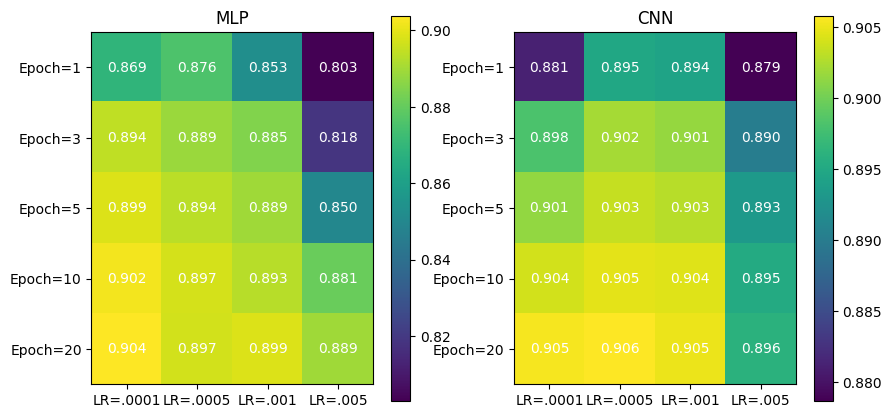

In [60]:
_, ax = plt.subplots(1,2, figsize=(10,5))
epochs_labels = ["Epoch=1", "Epoch=3", "Epoch=5", "Epoch=10", "Epoch=20"]
lrs_labels = ["LR=.0001", "LR=.0005", "LR=.001", "LR=.005"]

im_mlp = ax[0].imshow(mlp_score_list)
for i in range(len(epochs_labels)):
    for j in range(len(lrs_labels)):
        text = ax[0].text(j, i, f'{mlp_score_list[i, j]:.3f}',
                       ha="center", va="center", color="w")
ax[0].set_xticks(np.arange(len(lrs_labels)), labels=lrs_labels)
ax[0].set_yticks(np.arange(len(epochs_labels)), labels=epochs_labels)
ax[0].set_title("MLP")
cbar_mlp = ax[0].figure.colorbar(im_mlp, ax=ax[0])

im_cnn = ax[1].imshow(cnn_score_list)
for i in range(len(epochs_labels)):
    for j in range(len(lrs_labels)):
        text = ax[1].text(j, i, f'{cnn_score_list[i, j]:.3f}',
                       ha="center", va="center", color="w")
ax[1].set_xticks(np.arange(len(lrs_labels)), labels=lrs_labels)
ax[1].set_yticks(np.arange(len(epochs_labels)), labels=epochs_labels)
ax[1].set_title("CNN")
cbar_cnn = ax[1].figure.colorbar(im_cnn, ax=ax[1])
plt.show()